In [8]:
import os
os.getcwd()

'/lambda_stor/homes/ac.tfeng/git/DrugCell'

In [9]:
# import anndata
import numpy as np
import pandas as pd
from typing import List, Union, Optional, Tuple

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import MultivariateNormal

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="4"

import copy

import tqdm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [10]:
from codes.utils.util import *
from codes.drugcell_NN import *

if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'
  
torch.cuda.device_count()

8

In [11]:
!nvidia-smi

Tue Dec 19 09:11:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:1A:00.0 Off |                    0 |
| N/A   23C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
DEVICE = 'cuda:6'

# Data Loading

## GDSC

In [13]:
train_sample_idx = pd.read_csv("data/GDSC/GDSCv1_split_0_train.txt")
train_sample_idx = list(train_sample_idx.iloc[:,0])
test_sample_idx = pd.read_csv("data/GDSC/GDSCv1_split_0_test.txt")
test_sample_idx = list(test_sample_idx.iloc[:,0])

In [14]:
def set_col_names_in_multilevel_dataframe(
    df: pd.DataFrame,
    level_map: dict,
    gene_system_identifier: Union[str, List[str]]="Gene_Symbol") -> pd.DataFrame:
    """ Util function that supports loading of the omic data files.
    Returns the input dataframe with the multi-level column names renamed as
    specified by the gene_system_identifier arg.

    Args:
        df (pd.DataFrame): omics dataframe
        level_map (dict): encodes the column level and the corresponding identifier systems
        gene_system_identifier (str or list of str): gene identifier system to use
            options: "Entrez", "Gene_Symbol", "Ensembl", "all", or any list
                     combination of ["Entrez", "Gene_Symbol", "Ensembl"]

    Returns:
        pd.DataFrame: the input dataframe with the specified multi-level column names
    """
    df = df.copy()

    level_names = list(level_map.keys())
    level_values = list(level_map.values())
    n_levels = len(level_names)
    
    if isinstance(gene_system_identifier, list) and len(gene_system_identifier) == 1:
        gene_system_identifier = gene_system_identifier[0]

    # print(gene_system_identifier)
    # import pdb; pdb.set_trace()
    if isinstance(gene_system_identifier, str):
        if gene_system_identifier == "all":
            df.columns = df.columns.rename(level_names, level=level_values)  # assign multi-level col names
        else:
            df.columns = df.columns.get_level_values(level_map[gene_system_identifier])  # retian specific column level
    else:
        assert len(gene_system_identifier) <= n_levels, f"'gene_system_identifier' can't contain more than {n_levels} items."
        set_diff = list(set(gene_system_identifier).difference(set(level_names)))
        assert len(set_diff) == 0, f"Passed unknown gene identifiers: {set_diff}"
        kk = {i: level_map[i] for i in level_map if i in gene_system_identifier}
        # print(list(kk.keys()))
        # print(list(kk.values()))
        df.columns = df.columns.rename(list(kk.keys()), level=kk.values())  # assign multi-level col names
        drop_levels = list(set(level_map.values()).difference(set(kk.values())))
        df = df.droplevel(level=drop_levels, axis=1)
    return df


def load_gene_expression_data(gene_expression_file_path, 
    gene_system_identifier: Union[str, List[str]]="Gene_Symbol",
    sep: str="\t",
    verbose: bool=True) -> pd.DataFrame:
    """
    Returns gene expression data.

    Args:
        gene_system_identifier (str or list of str): gene identifier system to use
            options: "Entrez", "Gene_Symbol", "Ensembl", "all", or any list
                     combination of ["Entrez", "Gene_Symbol", "Ensembl"]

    Returns:
        pd.DataFrame: dataframe with the omic data
    """
    # level_map encodes the relationship btw the column and gene identifier system
    level_map = {"Ensembl": 0, "Entrez": 1, "Gene_Symbol": 2}
    header = [i for i in range(len(level_map))]

    df = pd.read_csv(gene_expression_file_path, sep=sep, index_col=0, header=header)

    df.index.name = "improve_sample_id"  # assign index name
    df = set_col_names_in_multilevel_dataframe(df, level_map, gene_system_identifier)
    if verbose:
        print(f"Gene expression data: {df.shape}")
    return df

In [15]:
gene_express = load_gene_expression_data("data/GDSC/cancer_gene_expression.tsv")

Gene expression data: (1007, 30805)


In [16]:
np.min(np.max(gene_express))

/homes/ac.tfeng/miniconda3/envs/general/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0.0

In [17]:
gene_express

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PANO1,XGY2,FLJ43315,LOC105377369,PRRC2B,UGT1A3,UGT1A5,F8A2,LOC105377063,F8A1
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
ACH-000016,4.189825,0.0,6.126601,2.114367,2.235727,0.000000,7.094553,5.907131,6.029453,3.669027,...,0.443607,0.000000,0.000000,0.000000,5.838700,0.321928,0.163499,0.042644,0.000000,3.356144
ACH-000032,0.070389,0.0,5.883376,3.549669,5.307064,0.028569,0.070389,0.286881,4.758090,5.542568,...,1.189034,0.238787,0.042644,0.000000,7.320124,0.000000,0.000000,0.000000,0.000000,5.493455
ACH-000033,4.682573,0.0,6.949185,1.823749,3.837943,0.028569,0.790772,6.224002,4.825786,4.408032,...,0.963474,0.111031,0.367371,0.070389,5.638364,0.000000,0.000000,0.000000,0.704872,3.270529
ACH-000043,3.499527,0.0,6.612647,1.952334,2.726831,0.070389,5.630813,6.098664,5.210623,3.148934,...,0.895303,0.056584,0.028569,0.000000,4.616475,0.000000,0.000000,0.000000,0.000000,3.726831
ACH-000049,4.262283,0.0,6.536985,2.087463,4.051372,0.028569,2.807355,6.387328,3.507160,4.163499,...,0.367371,0.000000,0.000000,0.000000,5.529196,0.000000,0.000000,0.000000,0.000000,4.144046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-001239,4.161888,0.0,6.267349,2.572890,3.729009,0.163499,0.903038,6.166715,4.543496,3.340562,...,0.584963,0.000000,0.000000,0.000000,5.712321,0.000000,0.000000,0.000000,0.000000,4.305241
ACH-001306,3.581351,0.0,6.933809,1.859970,3.560715,0.000000,3.979111,4.281698,3.405992,4.519164,...,1.049631,0.000000,0.000000,0.000000,6.444766,0.000000,0.000000,1.292782,0.000000,4.650765
ACH-001307,3.988230,0.0,7.027464,1.835924,3.704872,0.000000,0.485427,5.891905,3.667892,4.064366,...,0.704872,0.000000,0.014355,0.000000,6.727648,0.000000,0.000000,0.000000,0.000000,4.426265


In [18]:
response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
response

/tmp/ipykernel_458042/2325377014.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')


,source,improve_sample_id,improve_chem_id,study,auc,ic50,ec50,ec50se,r2fit,einf,hs,aac1,auc1,dss1
0,CCLE,ACH-000956,Drug_749,fake_exp,0.7153,5.6600,5.6600,0.6867,0.9533,0.0000,0.6669,0.2240,0.7760,0.1661
1,CCLE,ACH-000956,Drug_1326,fake_exp,0.9579,NaN,7.0230,0.7111,0.4332,0.9164,4.0000,0.0459,0.9541,0.0000
2,CCLE,ACH-000956,Drug_490,fake_exp,0.4130,7.5460,7.5510,0.0385,0.9948,0.0082,1.3380,0.6909,0.3091,0.6605
3,CCLE,ACH-000956,Drug_558,fake_exp,0.8004,5.1980,5.1980,11.7100,0.9944,0.0000,4.0000,0.0392,0.9608,0.0291
4,CCLE,ACH-000956,Drug_895,fake_exp,0.5071,7.0930,7.1490,0.3175,0.8069,0.0607,1.0150,0.5470,0.4530,0.5037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587704,GDSCv2,ACH-000475,Drug_470,19498,0.9548,NaN,7.8900,0.0000,-0.0000,0.9096,0.0000,0.0452,0.9548,0.0000
587705,GDSCv2,ACH-000475,Drug_343,19498,0.8190,3.0070,3.0070,46.7600,0.4604,0.0000,0.1818,0.1943,0.8057,0.1047
587706,GDSCv2,ACH-000475,Drug_1190,19498,0.9105,NaN,3.4040,0.0000,-0.0000,0.8209,0.0000,0.0895,0.9105,0.0000
587707,GDSCv2,ACH-000475,Drug_89,19498,0.9566,0.2428,0.2428,233.0000,0.1946,0.0000,0.2200,0.0438,0.9562,0.0000


In [19]:
gdsc_info = pd.read_csv("data/GDSC/GDSC_info.csv")

In [20]:
gdsc_info[gdsc_info['ModelID'] == 'ACH-000475']

,ModelID,PatientID,CellLineName,StrippedCellLineName,Age,SourceType,SangerModelID,RRID,DepmapModelType,AgeCategory,...,PublicComments,WTSIMasterCellID,EngineeredModel,TreatmentStatus,OnboardedMedia,PlateCoating,OncotreeCode,OncotreeSubtype,OncotreePrimaryDisease,OncotreeLineage
472,ACH-000475,PT-fHVhJI,huH-1,HUH1,53.0,Commercial,SIDM00586,CVCL_2956,HCC,Adult,...,NaN,1855.0,NaN,NaN,MF-002-001,None,HCC,Hepatocellular Carcinoma,Hepatocellular Carcinoma,Liver


In [21]:
gdsc = pd.merge(gene_express, gdsc_info, how="inner", left_on=["improve_sample_id"], right_on=['ModelID'])

In [22]:
gdsc_x = gdsc.loc[:, gene_express.columns]
gdsc_y = gdsc.loc[:, 'DepmapModelType']

In [23]:
gdsc_x

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PANO1,XGY2,FLJ43315,LOC105377369,PRRC2B,UGT1A3,UGT1A5,F8A2,LOC105377063,F8A1
0,4.189825,0.0,6.126601,2.114367,2.235727,0.000000,7.094553,5.907131,6.029453,3.669027,...,0.443607,0.000000,0.000000,0.000000,5.838700,0.321928,0.163499,0.042644,0.000000,3.356144
1,0.070389,0.0,5.883376,3.549669,5.307064,0.028569,0.070389,0.286881,4.758090,5.542568,...,1.189034,0.238787,0.042644,0.000000,7.320124,0.000000,0.000000,0.000000,0.000000,5.493455
2,4.682573,0.0,6.949185,1.823749,3.837943,0.028569,0.790772,6.224002,4.825786,4.408032,...,0.963474,0.111031,0.367371,0.070389,5.638364,0.000000,0.000000,0.000000,0.704872,3.270529
3,3.499527,0.0,6.612647,1.952334,2.726831,0.070389,5.630813,6.098664,5.210623,3.148934,...,0.895303,0.056584,0.028569,0.000000,4.616475,0.000000,0.000000,0.000000,0.000000,3.726831
4,4.262283,0.0,6.536985,2.087463,4.051372,0.028569,2.807355,6.387328,3.507160,4.163499,...,0.367371,0.000000,0.000000,0.000000,5.529196,0.000000,0.000000,0.000000,0.000000,4.144046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,4.161888,0.0,6.267349,2.572890,3.729009,0.163499,0.903038,6.166715,4.543496,3.340562,...,0.584963,0.000000,0.000000,0.000000,5.712321,0.000000,0.000000,0.000000,0.000000,4.305241
1003,3.581351,0.0,6.933809,1.859970,3.560715,0.000000,3.979111,4.281698,3.405992,4.519164,...,1.049631,0.000000,0.000000,0.000000,6.444766,0.000000,0.000000,1.292782,0.000000,4.650765
1004,3.988230,0.0,7.027464,1.835924,3.704872,0.000000,0.485427,5.891905,3.667892,4.064366,...,0.704872,0.000000,0.014355,0.000000,6.727648,0.000000,0.000000,0.000000,0.000000,4.426265
1005,3.983678,0.0,6.610287,2.330558,3.770829,0.056584,1.855990,7.816856,5.713421,4.729553,...,0.925999,0.084064,0.150560,0.000000,5.300490,0.042644,0.000000,1.084064,0.000000,2.689299


In [24]:
gdsc_y

0         CCRCC
1           BLL
2          LUAD
3       ZFIBSKI
4       ZIMMEKC
         ...   
1002        MEL
1003       THAP
1004       THAP
1005        HCC
1006       THME
Name: DepmapModelType, Length: 1007, dtype: object

## Gene ontology

In [25]:
training_file = "data/drugcell_train.txt"
testing_file = "data/drugcell_test.txt"
val_file = "data/drugcell_val.txt"
cell2id_file = "data/cell2ind.txt"
drug2id_file = "data/drug2ind.txt"
genotype_file = "data/cell2mutation.txt"
fingerprint_file = "data/drug2fingerprint.txt"
onto_file = "data/drugcell_ont.txt"
gene2id_file = "data/gene2ind.txt"

train_data, feature_dict, cell2id_mapping, drug2id_mapping = prepare_train_data(training_file, 
                                                                  testing_file, cell2id_file, 
                                                                  drug2id_file)

gene2id_mapping = load_mapping(gene2id_file)

# load cell/drug features
cell_features = np.genfromtxt(genotype_file, delimiter=',')
drug_features = np.genfromtxt(fingerprint_file, delimiter=',')

num_cells = len(cell2id_mapping)
num_drugs = len(drug2id_mapping)
num_genes = len(gene2id_mapping)
drug_dim = len(drug_features[0,:])

# load ontology
dG, root, term_size_map, \
    term_direct_gene_map = load_ontology(onto_file, 
                                         gene2id_mapping)

Total number of cell lines = 1225
Total number of drugs = 684
There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets


### Intersect of DCell and GDSC

In [26]:
len(list(set(gene2id_mapping.keys()) & set(gdsc_x.columns)))

2983

### Align gene id with GDCS

In [27]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(gdsc_x.columns))
gdsc_tensor = torch.zeros(gdsc_x.shape[0], num_genes)

In [28]:
for gene in gene_intersect_list:
    idx = gene2id_mapping[gene]
    gdsc_tensor[:,idx] = torch.tensor(gdsc_x[gene])

In [29]:
gdsc_y.value_counts()

LUAD     74
COAD     50
SCLC     48
GB       42
PAAD     38
         ..
FIBS      1
BTMOV     1
BPLL      1
PANET     1
SCCO      1
Name: DepmapModelType, Length: 138, dtype: int64

In [30]:
np.sum(gdsc_y.value_counts() >1)

91

In [31]:
cancer_2_idx = {}
idx_2_cancer = {}
cancer_type_idx = []

i = 0
for cancer in gdsc_y:
    if cancer not in cancer_2_idx:
        cancer_2_idx[cancer] = i
        idx_2_cancer[i] = cancer
        cancer_type_idx.append(i)
        
        i += 1
    else:
        cancer_type_idx.append(cancer_2_idx[cancer])

In [32]:
cancer_2_idx

{'CCRCC': 0,
 'BLL': 1,
 'LUAD': 2,
 'ZFIBSKI': 3,
 'ZIMMEKC': 4,
 'RMS': 5,
 'ZIMMLUNG': 6,
 'MCL': 7,
 'ZFIBBON': 8,
 'CML': 9,
 'MTNN': 10,
 'ZFIBSOF': 11,
 'AMLGATA2MECOM': 12,
 'COAD': 13,
 'PAAD': 14,
 'STAD': 15,
 'ATLL': 16,
 'ZFIBLYM': 17,
 'DLBCLNOS': 18,
 'ABC': 19,
 'AML': 20,
 'ZIMMEPCP': 21,
 'ATRT': 22,
 'UCEC': 23,
 'SCLC': 24,
 'ESCA': 25,
 'ZFIBBRE': 26,
 'TSTAD': 27,
 'ZFIBUPA': 28,
 'BRCNOS': 29,
 'GB': 30,
 'MOV': 31,
 'RCC': 32,
 'CHS': 33,
 'PCM': 34,
 'ZIMMOV': 35,
 'ZFIBLUN': 36,
 'MRT': 37,
 'LUSC': 38,
 'AMKL': 39,
 'MYCF': 40,
 'MNG': 41,
 'HGSOC': 42,
 'ZIMMBR': 43,
 'PLEMESO': 44,
 'PAASC': 45,
 'OCSC': 46,
 'ESCC': 47,
 'BLCA': 48,
 'MEL': 49,
 'IHCH': 50,
 'LCLC': 51,
 'ZFIBCOL': 52,
 'PRAD': 53,
 'AM': 54,
 'AMOL': 55,
 'BRCA': 56,
 'NSCLC': 57,
 'SARCNOS': 58,
 'ES': 59,
 'ASTR': 60,
 'ILC': 61,
 'PRCC': 62,
 'EOV': 63,
 'ALCLALKP': 64,
 'FIBS': 65,
 'MBL': 66,
 'THFO': 67,
 'BLLBCRABL1': 68,
 'ODG': 69,
 'HL': 70,
 'CMLBCRABL1': 71,
 'NBL': 72,
 'OS':

# Model training

In [33]:
class dcell_vae(nn.Module):

    def __init__(self, term_size_map, term_direct_gene_map, dG, ngene, root, 
                 num_hiddens_genotype, num_hiddens_final, n_class, inter_loss_penalty = 0.2):

        super(dcell_vae, self).__init__()

        self.root = root
        self.num_hiddens_genotype = num_hiddens_genotype
        self.num_hiddens_final = num_hiddens_final
        self.n_class = n_class
        self.inter_loss_penalty = inter_loss_penalty
        self.dG = copy.deepcopy(dG)

        # dictionary from terms to genes directly annotated with the term
        self.term_direct_gene_map = term_direct_gene_map

        self.term_visit_count = {}
        self.init_term_visits(term_size_map)
        
        # calculate the number of values in a state (term): term_size_map is the number of all genes annotated with the term
        self.term_dim_map = {}
        self.cal_term_dim(term_size_map)

        # ngenes, gene_dim are the number of all genes
        self.gene_dim = ngene

        # add modules for neural networks to process genotypes
        self.contruct_direct_gene_layer()
        self.construct_NN_graph(self.dG)

        # add modules for final layer TODO: modify it into VAE
        final_input_size = num_hiddens_genotype # + num_hiddens_drug[-1]
        self.add_module('final_linear_layer', nn.Linear(final_input_size, num_hiddens_final * 2))
        self.add_module('final_batchnorm_layer', nn.BatchNorm1d(num_hiddens_final * 2))
        self.add_module('final_aux_linear_layer', nn.Linear(num_hiddens_final * 2, 1))
        self.add_module('final_linear_layer_output', nn.Linear(1, 1))
        
        self.decoder_affine = nn.Linear(num_hiddens_final, n_class)

    def init_term_visits(self, term_size_map):
        
        for term in term_size_map:
            self.term_visit_count[term] = 0
    
    # calculate the number of values in a state (term)
    def cal_term_dim(self, term_size_map):

        for term, term_size in term_size_map.items():
            num_output = self.num_hiddens_genotype

            # log the number of hidden variables per each term
            num_output = int(num_output)
#            print("term\t%s\tterm_size\t%d\tnum_hiddens\t%d" % (term, term_size, num_output))
            self.term_dim_map[term] = num_output


    # build a layer for forwarding gene that are directly annotated with the term
    def contruct_direct_gene_layer(self):

        for term, gene_set in self.term_direct_gene_map.items():
            if len(gene_set) == 0:
                print('There are no directed asscoiated genes for', term)
                sys.exit(1)

            # if there are some genes directly annotated with the term, add a layer taking in all genes and forwarding out only those genes
            self.add_module(term+'_direct_gene_layer', nn.Linear(self.gene_dim, len(gene_set)))

    # start from bottom (leaves), and start building a neural network using the given ontology
    # adding modules --- the modules are not connected yet
    def construct_NN_graph(self, dG):

        self.term_layer_list = []   # term_layer_list stores the built neural network
        self.term_neighbor_map = {}

        # term_neighbor_map records all children of each term
        for term in dG.nodes():
            self.term_neighbor_map[term] = []
            for child in dG.neighbors(term):
                self.term_neighbor_map[term].append(child)

        while True:
            leaves = [n for n in dG.nodes() if dG.out_degree(n) == 0]
            #leaves = [n for n,d in dG.out_degree().items() if d==0]
            #leaves = [n for n,d in dG.out_degree() if d==0]

            if len(leaves) == 0:
                break

            self.term_layer_list.append(leaves)

            for term in leaves:

                # input size will be #chilren + #genes directly annotated by the term
                input_size = 0

                for child in self.term_neighbor_map[term]:
                    input_size += self.term_dim_map[child]

                if term in self.term_direct_gene_map:
                    input_size += len(self.term_direct_gene_map[term])

                # term_hidden is the number of the hidden variables in each state
                term_hidden = self.term_dim_map[term]

                self.add_module(term+'_linear_layer', nn.Linear(input_size, term_hidden))
                self.add_module(term+'_batchnorm_layer', nn.BatchNorm1d(term_hidden))
                self.add_module(term+'_aux_linear_layer1', nn.Linear(term_hidden, self.n_class))
                self.add_module(term+'_aux_linear_layer2', nn.Linear(self.n_class, self.n_class))

            dG.remove_nodes_from(leaves)


    # definition of encoder
    def encoder(self, x):
        gene_input = x.narrow(1, 0, self.gene_dim)

        # define forward function for genotype dcell #############################################
        term_gene_out_map = {}

        for term, _ in self.term_direct_gene_map.items():
            term_gene_out_map[term] = self._modules[term + '_direct_gene_layer'](gene_input)

        term_NN_out_map = {}
        aux_out_map = {}

        for i, layer in enumerate(self.term_layer_list):

            for term in layer:

                child_input_list = []

                self.term_visit_count[term] += 1
                
                for child in self.term_neighbor_map[term]:
                    child_input_list.append(term_NN_out_map[child])

                if term in self.term_direct_gene_map:
                    child_input_list.append(term_gene_out_map[term])

                child_input = torch.cat(child_input_list,1)

                term_NN_out = self._modules[term+'_linear_layer'](child_input)

                Tanh_out = torch.tanh(term_NN_out)
                term_NN_out_map[term] = self._modules[term+'_batchnorm_layer'](Tanh_out)
                aux_layer1_out = torch.tanh(self._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
                aux_out_map[term] = self._modules[term+'_aux_linear_layer2'](aux_layer1_out)

        # connect two neural networks at the top #################################################
        final_input = term_NN_out_map[self.root] # torch.cat((term_NN_out_map[self.root], drug_out), 1)

        out = self._modules['final_batchnorm_layer'](torch.tanh(self._modules['final_linear_layer'](final_input)))
        term_NN_out_map['final'] = out

        aux_layer_out = torch.tanh(self._modules['final_aux_linear_layer'](out))
        aux_out_map['final'] = self._modules['final_linear_layer_output'](aux_layer_out)

        return aux_out_map, term_NN_out_map
    
    def forward(self, x):
        
        aux_out_map, term_NN_out_map = self.encoder(x)
        
        mu = term_NN_out_map['final'][..., :self.num_hiddens_final]
        log_var = term_NN_out_map['final'][..., :self.num_hiddens_final]  # T X batch X z_dim
        std_dec = log_var.mul(0.5).exp_()
        # std_dec = 1
        
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(std_dec))
        z = latent.rsample()
        
        recon_mean = self.decoder_affine(z)
        logits = F.softmax(recon_mean, -1)

        return logits, mu, log_var, aux_out_map, term_NN_out_map
    
    def loss_log_vae(self, logits, y, mu, log_var, beta = 0.001):
        # y: true labels
        ori_y_shape = y.shape
        
        class_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), 
                                     y.reshape(-1), reduction = 'none').div(np.log(2)).view(*ori_y_shape)
        
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 
                              dim = -1)
        
        log_loss = class_loss + beta * KLD
        log_loss = torch.mean(torch.logsumexp(log_loss, 0))
        
        return log_loss
    
    def intermediate_loss(self, aux_out_map, y):
        
        inter_loss = 0
        for name, output in aux_out_map.items():
            if name == 'final':
                inter_loss += 0
            else: # change 0.2 to smaller one for big terms
                ori_y_shape = y.shape
        
                term_loss = F.cross_entropy(output, 
                                             y, 
                                             reduction = 'none').div(np.log(2)).view(*ori_y_shape)
                inter_loss += term_loss

        return inter_loss

In [34]:
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        if self.y is not None and self.c is None:
            return sample, self.y[index]
        elif self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        elif self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

In [35]:
torch.manual_seed(0)

y = torch.tensor(cancer_type_idx)
gdsc_dataset = RNASeqData(X = gdsc_tensor, y = y)
training_set, testing_set = random_split(gdsc_dataset, [0.8, 0.2])

In [36]:
train_epochs = 200

train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)
(inputdata, response) = next(iter(train_loader))

In [37]:
len(testing_set)

201

In [38]:
def create_term_mask(term_direct_gene_map, gene_dim, device):

    term_mask_map = {}

    for term, gene_set in term_direct_gene_map.items():

        mask = torch.zeros(len(gene_set), gene_dim)

        for i, gene_id in enumerate(gene_set):
            mask[i, gene_id] = 1

        mask_gpu = torch.autograd.Variable(mask)

        term_mask_map[term] = mask_gpu.to(device)

    return term_mask_map



In [33]:
num_hiddens_genotype = 6
num_hiddens_final = 6

model = dcell_vae(term_size_map, term_direct_gene_map, dG, num_genes, 
                 root, num_hiddens_genotype, num_hiddens_final, n_class = len(cancer_2_idx))
model.to(DEVICE)
term_mask_map = create_term_mask(model.term_direct_gene_map, num_genes, device = DEVICE)


learning_rate = 0.001
torch.manual_seed(0)
training_loss_list = []
accu_list = []
train_epochs = 100


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-05)
term_mask_map = create_term_mask(model.term_direct_gene_map, gene_dim=num_genes, device=DEVICE)

optimizer.zero_grad()

for name, param in model.named_parameters():
    term_name = name.split('_')[0]

    if '_direct_gene_layer.weight' in name:
        param.data = torch.mul(param.data, term_mask_map[term_name].to(DEVICE)) * 0.1
    else:
        param.data = param.data * 0.1

tepoch = tqdm.tqdm(range(train_epochs))
for epoch in tepoch:
    # Train
    model.train()
    train_predict = torch.zeros(0, 0).to(DEVICE)

    for i, (data, response) in enumerate(train_loader):
        # Convert torch tensor to Variable

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer

        # Here term_NN_out_map is a dictionary
        recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(data.to(DEVICE))

        if train_predict.size()[0] == 0:
            train_predict = aux_out_map["final"].data
        else:
            train_predict = torch.cat([train_predict, aux_out_map["final"].data], dim=0)

        total_loss = 0

        loss_vae = model.loss_log_vae(
            logits=recon_mean, y=response.to(DEVICE), mu=mu, log_var=log_var, beta=0.001
        )

        loss_intermidiate = model.intermediate_loss(aux_out_map, response.to(DEVICE))

        total_loss = torch.mean(loss_vae + model.inter_loss_penalty * loss_intermidiate)
        
        tmp_loss = total_loss.item()
        
        total_loss.backward()

        for name, param in model.named_parameters():
            if "_direct_gene_layer.weight" not in name:
                continue
            term_name = name.split("_")[0]
            # print name, param.grad.data.size(), term_mask_map[term_name].size()
            param.grad.data = torch.mul(param.grad.data, term_mask_map[term_name])

        optimizer.step()
    
    (inputdata, response) = next(iter(test_loader))
    recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

    accu = torch.sum(torch.argmax(recon_mean, 1).cpu() == response)/len(response)
    
    tepoch.set_postfix({"Epoch": epoch, "Loss": tmp_loss, "Accuracy": accu.item()})
    
    training_loss_list.append(tmp_loss)
    accu_list.append(accu.item())
    # if epoch % 10 == 0:
    torch.save(model, "gdsc_50.pt")

 17%|█▋        | 17/100 [17:05<1:20:16, 58.04s/it, Epoch=16, Loss=2.36e+3, Accuracy=0.0498]

In [33]:
model = torch.load("gdsc_50.pt")

## Top 5 test

In [41]:
y_top5 = copy.deepcopy(cancer_type_idx)

for idx, y_tmp in enumerate(cancer_type_idx):
    if y_tmp in [2,13,24,30,14]:
        y_top5[idx] = 1
    else:
        y_top5[idx] = 0
    
y_top5_train = y_top5[:700]
y_top5_test = y_top5[700:]

In [42]:
torch.manual_seed(0)

y = torch.tensor(cancer_type_idx)
gdsc_dataset = RNASeqData(X = gdsc_tensor, y = torch.tensor(y_top5))
training_set, testing_set = random_split(gdsc_dataset, [0.8, 0.2])

In [43]:
train_epochs = 256

train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)
# (inputdata, response) = next(iter(train_loader))

In [44]:
def create_term_mask(term_direct_gene_map, gene_dim, device):

    term_mask_map = {}

    for term, gene_set in term_direct_gene_map.items():

        mask = torch.zeros(len(gene_set), gene_dim)

        for i, gene_id in enumerate(gene_set):
            mask[i, gene_id] = 1

        mask_gpu = torch.autograd.Variable(mask)

        term_mask_map[term] = mask_gpu.to(device)

    return term_mask_map

In [45]:
import pickle

In [60]:
for seed in range(10):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    training_set, testing_set = random_split(gdsc_dataset, [0.8, 0.2])
    train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

    num_hiddens_genotype = 6
    num_hiddens_final = 6

    model = dcell_vae(term_size_map, term_direct_gene_map, dG, num_genes, 
                    root, num_hiddens_genotype, num_hiddens_final, n_class = 2)
    model.to(DEVICE)
    term_mask_map = create_term_mask(model.term_direct_gene_map, num_genes, device = DEVICE)


    learning_rate = 0.001
    # torch.manual_seed(0)
    training_loss_list = []
    accu_list = []
    auc_list = []
    train_epochs = 50
    best_auc = 0


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-05)
    term_mask_map = create_term_mask(model.term_direct_gene_map, gene_dim=num_genes, device=DEVICE)

    optimizer.zero_grad()

    for name, param in model.named_parameters():
        term_name = name.split('_')[0]

        if '_direct_gene_layer.weight' in name:
            param.data = torch.mul(param.data, term_mask_map[term_name].to(DEVICE)) * 0.1
        else:
            param.data = param.data * 0.1

    tepoch = tqdm.tqdm(range(train_epochs))
    for epoch in tepoch:
        # Train
        model.train()
        train_predict = torch.zeros(0, 0).to(DEVICE)
        (inputdata_test, response_test) = next(iter(test_loader))
        
        for i, (data, response) in enumerate(train_loader):
            # Convert torch tensor to Variable

            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer

            # Here term_NN_out_map is a dictionary
            recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(data.to(DEVICE))

            if train_predict.size()[0] == 0:
                train_predict = aux_out_map["final"].data
            else:
                train_predict = torch.cat([train_predict, aux_out_map["final"].data], dim=0)

            total_loss = 0

            loss_vae = model.loss_log_vae(
                logits=recon_mean, y=response.to(DEVICE), mu=mu, log_var=log_var, beta=0.001
            )

            loss_intermidiate = model.intermediate_loss(aux_out_map, response.to(DEVICE))

            total_loss = torch.mean(loss_vae + model.inter_loss_penalty * loss_intermidiate)
            
            tmp_loss = total_loss.item()
            
            total_loss.backward()

            for name, param in model.named_parameters():
                if "_direct_gene_layer.weight" not in name:
                    continue
                term_name = name.split("_")[0]
                # print name, param.grad.data.size(), term_mask_map[term_name].size()
                param.grad.data = torch.mul(param.grad.data, term_mask_map[term_name])

            optimizer.step()
        
        model.eval()
        recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata_test.to(DEVICE))

        accu = torch.sum(torch.argmax(recon_mean, 1).detach().cpu() == response_test)/len(response_test)
        
        auc = roc_auc_score(response_test, recon_mean[:,1].detach().cpu())
        
        tepoch.set_postfix({"Epoch": epoch, "Loss": tmp_loss, "Accuracy": accu.item(), 'AUC': auc})
        
        training_loss_list.append(tmp_loss)
        accu_list.append(accu.item())
        auc_list.append(auc)
        # if epoch % 10 == 0:
        if auc > best_auc:
            torch.save(model, "gdsc_50_top5_data_"+str(seed)+".pt")
            best_auc = auc
    with open('loss_accu_top5_data_'+str(seed)+'.pkl', 'wb') as f:
        pickle.dump({'loss': training_loss_list,
                    'accu': accu_list,
                    'auc': auc_list,
                    'best_auc': best_auc}, f)

 38%|███▊      | 19/50 [13:01<20:23, 39.46s/it, Epoch=18, Loss=298, Accuracy=0.806, AUC=0.789]

In [ ]:
import pickle 

with open('loss_accu_top5_new.pkl', 'wb') as f:
    pickle.dump({'loss': training_loss_list,
                'accu': accu_list,
                'auc': auc_list}, f)

In [46]:
# num_hiddens_genotype = 6
# num_hiddens_final = 6

# model = dcell_vae(term_size_map, term_direct_gene_map, dG, num_genes, 
#                     root, num_hiddens_genotype, num_hiddens_final, n_class = 2)
model = torch.load("gdsc_50_top5_"+str(9)+".pt").to(DEVICE)

In [53]:
(inputdata, response) = next(iter(test_loader))
inputdata.shape

torch.Size([201, 3008])

In [60]:
auc_avg_list = []
for model_idx in range(10):
    model = torch.load("gdsc_50_top5_"+str(model_idx)+".pt").to(DEVICE)
    
    recon_mean_avg = 0
    for j in tqdm.tqdm(range(20)):
        recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))
        recon_mean_avg += recon_mean.cpu().detach()
        
    recon_mean_avg /= 20
    auc_avg = roc_auc_score(response, recon_mean_avg[:,1])
    auc_avg_list.append(auc_avg)

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


In [61]:
auc_avg_list

[0.8388829215896885,
 0.8842642320085928,
 0.8427765843179378,
 0.8782223415682062,
 0.8917830290010741,
 0.8646616541353385,
 0.8707035445757251,
 0.8654672395273899,
 0.8425080558539204,
 0.8441192266380236]

In [140]:
recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))


torch.sum(torch.argmax(recon_mean, 1).cpu() == response)/len(response)

tensor(0.8259)

In [ ]:
with open(r"loss_accu_top5.pkl", "rb") as input_file:
   res = pickle.load(input_file)

In [ ]:
for i in range(10):
    with open(r"loss_accu_top5"+str(i)+".pkl", "rb") as input_file:
        res = pickle.load(input_file)
        print(res['best_auc'])

# Adding drug embedding

In [39]:
class Drugcell_Vae(nn.Module):

    def __init__(self, term_size_map, term_direct_gene_map, dG, ngene, ndrug, root, 
                 num_hiddens_genotype, num_hiddens_drug, num_hiddens_final, 
                 n_class, inter_loss_penalty = 0.2):

        super().__init__()

        self.root = root
        self.num_hiddens_genotype = num_hiddens_genotype
        self.num_hiddens_drug = num_hiddens_drug
        
        
        self.num_hiddens_final = num_hiddens_final
        self.n_class = n_class
        self.inter_loss_penalty = inter_loss_penalty
        self.dG = copy.deepcopy(dG)

        # dictionary from terms to genes directly annotated with the term
        self.term_direct_gene_map = term_direct_gene_map

        self.term_visit_count = {}
        self.init_term_visits(term_size_map)
        
        # calculate the number of values in a state (term): term_size_map is the number of all genes annotated with the term
        self.term_dim_map = {}
        self.cal_term_dim(term_size_map)

        # ngenes, gene_dim are the number of all genes
        self.gene_dim = ngene
        self.drug_dim = ndrug

        # add modules for neural networks to process genotypes
        self.contruct_direct_gene_layer()
        self.construct_NN_graph(self.dG)

        # add modules for neural networks to process drugs
        self.construct_NN_drug()

        # add modules for final layer TODO: modify it into VAE
        final_input_size = num_hiddens_genotype + num_hiddens_drug[-1]
        self.add_module('final_linear_layer', nn.Linear(final_input_size, num_hiddens_final * 2))
        self.add_module('final_batchnorm_layer', nn.BatchNorm1d(num_hiddens_final * 2))
        self.add_module('final_aux_linear_layer', nn.Linear(num_hiddens_final * 2, 1))
        self.add_module('final_linear_layer_output', nn.Linear(1, 1))
        
        self.decoder_affine = nn.Linear(num_hiddens_final, 1)

    def init_term_visits(self, term_size_map):
        
        for term in term_size_map:
            self.term_visit_count[term] = 0
    
    # calculate the number of values in a state (term)
    def cal_term_dim(self, term_size_map):

        for term, term_size in term_size_map.items():
            num_output = self.num_hiddens_genotype

            # log the number of hidden variables per each term
            num_output = int(num_output)
#            print("term\t%s\tterm_size\t%d\tnum_hiddens\t%d" % (term, term_size, num_output))
            self.term_dim_map[term] = num_output


    # build a layer for forwarding gene that are directly annotated with the term
    def contruct_direct_gene_layer(self):

        for term, gene_set in self.term_direct_gene_map.items():
            if len(gene_set) == 0:
                print('There are no directed asscoiated genes for', term)
                sys.exit(1)

            # if there are some genes directly annotated with the term, add a layer taking in all genes and forwarding out only those genes
            self.add_module(term+'_direct_gene_layer', nn.Linear(self.gene_dim, len(gene_set)))


    # add modules for fully connected neural networks for drug processing
    def construct_NN_drug(self):
        input_size = self.drug_dim

        for i in range(len(self.num_hiddens_drug)):
            self.add_module('drug_linear_layer_' + str(i+1), nn.Linear(input_size, self.num_hiddens_drug[i]))
            self.add_module('drug_batchnorm_layer_' + str(i+1), nn.BatchNorm1d(self.num_hiddens_drug[i]))
            self.add_module('drug_aux_linear_layer1_' + str(i+1), nn.Linear(self.num_hiddens_drug[i],1))
            self.add_module('drug_aux_linear_layer2_' + str(i+1), nn.Linear(1,1))

            input_size = self.num_hiddens_drug[i]

    # start from bottom (leaves), and start building a neural network using the given ontology
    # adding modules --- the modules are not connected yet
    def construct_NN_graph(self, dG):

        self.term_layer_list = []   # term_layer_list stores the built neural network
        self.term_neighbor_map = {}

        # term_neighbor_map records all children of each term
        for term in dG.nodes():
            self.term_neighbor_map[term] = []
            for child in dG.neighbors(term):
                self.term_neighbor_map[term].append(child)

        while True:
            leaves = [n for n in dG.nodes() if dG.out_degree(n) == 0]
            #leaves = [n for n,d in dG.out_degree().items() if d==0]
            #leaves = [n for n,d in dG.out_degree() if d==0]

            if len(leaves) == 0:
                break

            self.term_layer_list.append(leaves)

            for term in leaves:

                # input size will be #chilren + #genes directly annotated by the term
                input_size = 0

                for child in self.term_neighbor_map[term]:
                    input_size += self.term_dim_map[child]

                if term in self.term_direct_gene_map:
                    input_size += len(self.term_direct_gene_map[term])

                # term_hidden is the number of the hidden variables in each state
                term_hidden = self.term_dim_map[term]

                self.add_module(term+'_linear_layer', nn.Linear(input_size, term_hidden))
                self.add_module(term+'_batchnorm_layer', nn.BatchNorm1d(term_hidden))
                self.add_module(term+'_aux_linear_layer1', nn.Linear(term_hidden, term_hidden))
                self.add_module(term+'_aux_linear_layer2', nn.Linear(term_hidden, 1))

            dG.remove_nodes_from(leaves)


    # definition of encoder
    def encoder(self, x):
        gene_input = x.narrow(1, 0, self.gene_dim)
        drug_input = x.narrow(1, self.gene_dim, self.drug_dim)
        
        # define forward function for genotype dcell #############################################
        term_gene_out_map = {}

        for term, _ in self.term_direct_gene_map.items():
            term_gene_out_map[term] = self._modules[term + '_direct_gene_layer'](gene_input)

        term_NN_out_map = {}
        aux_out_map = {}

        for i, layer in enumerate(self.term_layer_list):

            for term in layer:

                child_input_list = []

                self.term_visit_count[term] += 1
                
                for child in self.term_neighbor_map[term]:
                    child_input_list.append(term_NN_out_map[child])

                if term in self.term_direct_gene_map:
                    child_input_list.append(term_gene_out_map[term])

                child_input = torch.cat(child_input_list,1)

                term_NN_out = self._modules[term+'_linear_layer'](child_input)

                Tanh_out = torch.tanh(term_NN_out)
                term_NN_out_map[term] = self._modules[term+'_batchnorm_layer'](Tanh_out)
                aux_layer1_out = torch.tanh(self._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
                aux_out_map[term] = self._modules[term+'_aux_linear_layer2'](aux_layer1_out)

        drug_out = drug_input

        for i in range(1, len(self.num_hiddens_drug)+1, 1):
            drug_out = self._modules['drug_batchnorm_layer_'+str(i)]( torch.tanh(self._modules['drug_linear_layer_' + str(i)](drug_out)))
            term_NN_out_map['drug_'+str(i)] = drug_out

            aux_layer1_out = torch.tanh(self._modules['drug_aux_linear_layer1_'+str(i)](drug_out))
            aux_out_map['drug_'+str(i)] = self._modules['drug_aux_linear_layer2_'+str(i)](aux_layer1_out)


        # connect two neural networks at the top #################################################
        final_input = torch.cat((term_NN_out_map[self.root], drug_out), 1)

        out = self._modules['final_batchnorm_layer'](torch.tanh(self._modules['final_linear_layer'](final_input)))
        term_NN_out_map['final'] = out

        aux_layer_out = torch.tanh(self._modules['final_aux_linear_layer'](out))
        aux_out_map['final'] = self._modules['final_linear_layer_output'](aux_layer_out)

        return aux_out_map, term_NN_out_map
    
    def forward(self, x):
        
        aux_out_map, term_NN_out_map = self.encoder(x)
        
        mu = term_NN_out_map['final'][..., :self.num_hiddens_final]
        log_var = term_NN_out_map['final'][..., :self.num_hiddens_final]  # T X batch X z_dim
        std_dec = log_var.mul(0.5).exp_()
        # std_dec = 1
        
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(std_dec))
        z = latent.rsample()
        
        recon_mean = self.decoder_affine(z)
        recon_mean = F.sigmoid(recon_mean)

        return recon_mean, mu, log_var, aux_out_map, term_NN_out_map
    
    def loss_log_vae(self, recon_mean, y, mu, log_var, beta = 0.001):
        # y: true labels
        ori_y_shape = y.shape
        
        class_loss = F.mse_loss(recon_mean.view(-1), 
                                     y.reshape(-1), reduction = 'none').div(np.log(2)).view(*ori_y_shape)
        
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 
                              dim = -1)
        
        log_loss = class_loss + beta * KLD
        log_loss = torch.mean(torch.logsumexp(log_loss, 0))
        
        return log_loss
    
    def intermediate_loss(self, aux_out_map, y):
        
        inter_loss = 0
        for name, output in aux_out_map.items():
            if name == 'final':
                inter_loss += 0
            else: # change 0.2 to smaller one for big terms
                ori_y_shape = y.shape
        
                term_loss = F.mse_loss(output.view(-1), 
                                             y.reshape(-1), 
                                             reduction = 'none').div(np.log(2)).view(*ori_y_shape)
                inter_loss += term_loss

        return inter_loss

In [40]:
train_feature, train_label, test_feature, test_label = train_data

In [41]:
train_feature.shape

torch.Size([10000, 2])

In [33]:
train_loader = du.DataLoader(du.TensorDataset(train_feature,train_label),
                                 batch_size=32, shuffle=False)

NameError: name 'train_feature' is not defined

In [42]:
cell_features = np.genfromtxt(genotype_file, delimiter=',')
drug_features = np.genfromtxt(fingerprint_file, delimiter=',')

In [43]:
drug_ecfp4_nbits512 = pd.read_csv("data/GDSC/drug_ecfp4_nbits512.tsv", sep = '\t', index_col=0)
drug_ecfp4_nbits512

,ecfp4.0,ecfp4.1,ecfp4.2,ecfp4.3,ecfp4.4,ecfp4.5,ecfp4.6,ecfp4.7,ecfp4.8,ecfp4.9,...,ecfp4.502,ecfp4.503,ecfp4.504,ecfp4.505,ecfp4.506,ecfp4.507,ecfp4.508,ecfp4.509,ecfp4.510,ecfp4.511
improve_chem_id,,,,,,,,,,,,,,,,,,,,,
Drug_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Drug_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Drug_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Drug_100,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Drug_1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Drug_995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
Drug_996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Drug_997,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
genedim = len(cell_features[0,:])
drugdim = len(drug_features[0,:])
print(genedim)
print(drugdim)
feature = np.zeros((inputdata.size()[0], (genedim+drugdim)))
#print(input_data)
print(inputdata.size()[0])
#print(drug_features)

for i in range(inputdata.size()[0]):
    #print(int(input_data[i,0]))
    try:
        feature[i] = np.concatenate((cell_features[int(inputdata[i,0])], 
                                        drug_features[int(inputdata[i,1])]), axis=None)
    except IndexError:
        pass

feature = torch.from_numpy(feature).float()

3008
2048
64


In [45]:
genedim = len(cell_features[0,:])
drugdim = len(drug_features[0,:])

In [46]:
response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
response

/tmp/ipykernel_458042/2325377014.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')


,source,improve_sample_id,improve_chem_id,study,auc,ic50,ec50,ec50se,r2fit,einf,hs,aac1,auc1,dss1
0,CCLE,ACH-000956,Drug_749,fake_exp,0.7153,5.6600,5.6600,0.6867,0.9533,0.0000,0.6669,0.2240,0.7760,0.1661
1,CCLE,ACH-000956,Drug_1326,fake_exp,0.9579,NaN,7.0230,0.7111,0.4332,0.9164,4.0000,0.0459,0.9541,0.0000
2,CCLE,ACH-000956,Drug_490,fake_exp,0.4130,7.5460,7.5510,0.0385,0.9948,0.0082,1.3380,0.6909,0.3091,0.6605
3,CCLE,ACH-000956,Drug_558,fake_exp,0.8004,5.1980,5.1980,11.7100,0.9944,0.0000,4.0000,0.0392,0.9608,0.0291
4,CCLE,ACH-000956,Drug_895,fake_exp,0.5071,7.0930,7.1490,0.3175,0.8069,0.0607,1.0150,0.5470,0.4530,0.5037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587704,GDSCv2,ACH-000475,Drug_470,19498,0.9548,NaN,7.8900,0.0000,-0.0000,0.9096,0.0000,0.0452,0.9548,0.0000
587705,GDSCv2,ACH-000475,Drug_343,19498,0.8190,3.0070,3.0070,46.7600,0.4604,0.0000,0.1818,0.1943,0.8057,0.1047
587706,GDSCv2,ACH-000475,Drug_1190,19498,0.9105,NaN,3.4040,0.0000,-0.0000,0.8209,0.0000,0.0895,0.9105,0.0000
587707,GDSCv2,ACH-000475,Drug_89,19498,0.9566,0.2428,0.2428,233.0000,0.1946,0.0000,0.2200,0.0438,0.9562,0.0000


In [47]:
improve_sample_key_id_dict = {k: v for v, k in enumerate(response['improve_sample_id'].unique())}
improve_sample_id_key_dict = {v: k for v, k in enumerate(response['improve_sample_id'].unique())}

In [48]:
chem_key_id_dict = {k: v for v, k in enumerate(response['improve_sample_id'].unique())}
chem_id_key_dict = {v: k for v, k in enumerate(response['improve_sample_id'].unique())}

In [49]:
drug_ecfp4_nbits512.loc[['Drug_749', 'Drug_36'],:].to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [50]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(gdsc_x.columns))
gdsc_tensor = torch.zeros(gene_express.shape[0], num_genes)

In [51]:
for gene in gene_intersect_list:
    idx = gene2id_mapping[gene]
    gdsc_tensor[:,idx] = torch.tensor(gene_express[gene])

In [52]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(gdsc_x.columns))
# gdsc_tensor = torch.zeros(gene_express.shape[0], num_genes)
gdsc_row_key_id = {k: v for v, k in enumerate(gene_express.index)}
gdsc_row_id_key = {v: k for v, k in enumerate(gene_express.index)}

chem_row_key_id = {k: v for v, k in enumerate(drug_ecfp4_nbits512.index)}
chem_row_id_key = {v: k for v, k in enumerate(drug_ecfp4_nbits512.index)}

In [53]:
drug_tensor = torch.tensor(drug_ecfp4_nbits512.to_numpy())

In [54]:
response_gdcs2 = response[response['source'] == 'GDSCv2'].loc[:,['improve_sample_id', 
                                                             'improve_chem_id',
                                                             'auc']]

In [55]:
response_gdcs2 = response_gdcs2.replace({'improve_sample_id': gdsc_row_key_id})
response_gdcs2 = response_gdcs2.replace({'improve_chem_id': chem_row_key_id})
response_gdcs2 = torch.tensor(response_gdcs2.to_numpy())

In [56]:
response_gdcs2

tensor([[9.4900e+02, 6.7400e+02, 5.8330e-01],
        [9.4900e+02, 6.7400e+02, 6.0260e-01],
        [9.4900e+02, 6.7400e+02, 4.3030e-01],
        ...,
        [5.1500e+02, 2.1400e+02, 9.1050e-01],
        [5.1500e+02, 1.4430e+03, 9.5660e-01],
        [5.1500e+02, 8.5500e+02, 8.4260e-01]], dtype=torch.float64)

In [57]:
len(np.unique(list(zip(response_gdcs2[:,:2]))))

586

In [58]:
a = response_gdcs2[:,:2].numpy()

In [59]:
a.shape

(114644, 2)

In [60]:
a_unique = np.unique(a, axis = 0)

In [61]:
a_unique.shape

(66353, 2)

In [62]:
class GDSCData(Dataset):
    
    def __init__(self, response, gene_tensor, chem_tensor):
        self.response = response
        self.gene_tensor = gene_tensor
        self.chem_tensor = chem_tensor
        
    def __len__(self):
        return self.response.shape[0]
    
    def __getitem__(self, index):
        sample = self.response[index,:]
        
        X_gene = self.gene_tensor[sample[0].long() ,:]
        X_chem = self.chem_tensor[sample[1].long() ,:]
        
        y = sample[2]

        X = torch.cat((X_gene, X_chem), 0)
        
        return X, y

In [63]:
train_gdcs_idx = torch.unique(response_gdcs2[:,0], sorted=False)[:423]
test_gdcs_idx = torch.unique(response_gdcs2[:,0], sorted=False)[423:]

In [64]:
gdsc_data = GDSCData(response_gdcs2, gdsc_tensor, drug_tensor)
gdsc_data_train = GDSCData(response_gdcs2[torch.isin(response_gdcs2[:,0], train_gdcs_idx)].float(), gdsc_tensor, drug_tensor)
gdsc_data_test = GDSCData(response_gdcs2[torch.isin(response_gdcs2[:,0], test_gdcs_idx)].float(), gdsc_tensor, drug_tensor)

In [65]:
train_GDSC_np = response_gdcs2[torch.isin(response_gdcs2[:,0], train_gdcs_idx)].float().numpy()
test_GDSC_np = response_gdcs2[torch.isin(response_gdcs2[:,0], test_gdcs_idx)].float().numpy()

In [66]:
np.unique(train_GDSC_np[:,:2], axis=0).shape

(59389, 2)

In [67]:
np.unique(test_GDSC_np[:,:2], axis=0).shape

(6964, 2)

In [68]:
train_loader = DataLoader(gdsc_data_train, batch_size=8192, shuffle=True)
test_loader = DataLoader(gdsc_data_test, batch_size=8192, shuffle=False)
(inputdata, response) = next(iter(test_loader))

In [69]:
(inputdata, response) = next(iter(train_loader))

In [70]:
inputdata

tensor([[1.0909, 2.1043, 2.8480,  ..., 0.0000, 0.0000, 0.0000],
        [0.1243, 4.4555, 1.7655,  ..., 0.0000, 1.0000, 0.0000],
        [0.3448, 3.8227, 3.8866,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.3334, 3.8063, 3.3827,  ..., 0.0000, 0.0000, 1.0000],
        [1.0909, 3.0807, 1.9411,  ..., 0.0000, 0.0000, 0.0000],
        [0.0566, 1.9373, 2.5236,  ..., 0.0000, 0.0000, 0.0000]])

In [71]:
len(gdsc_data_test)

19271

In [96]:
torch.manual_seed(1)

num_hiddens_genotype = 6
num_hiddens_final = 6
drug_hiddens='100,50,6'
num_hiddens_drug = list(map(int, drug_hiddens.split(',')))
# num_hiddens_drug = 6
num_drugs = drug_ecfp4_nbits512.shape[1]

model = Drugcell_Vae(term_size_map, term_direct_gene_map, dG, num_genes, num_drugs, 
                 root, num_hiddens_genotype, num_hiddens_drug, num_hiddens_final, 
                 n_class = len(cancer_2_idx))
model.to(DEVICE)
term_mask_map = create_term_mask(model.term_direct_gene_map, num_genes, device = DEVICE)


learning_rate = 0.001
torch.manual_seed(0)
training_loss_list = []
testing_loss_list = []
epoch_list = []
accu_list = []
train_epochs = 50
best_loss = 1000


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-05)
term_mask_map = create_term_mask(model.term_direct_gene_map, gene_dim=num_genes, device=DEVICE)

optimizer.zero_grad()

for name, param in model.named_parameters():
    term_name = name.split('_')[0]

    if '_direct_gene_layer.weight' in name:
        param.data = torch.mul(param.data, term_mask_map[term_name].to(DEVICE)) * 0.1
    else:
        param.data = param.data * 0.1

mse_tmp_testing = torch.tensor(0, device=DEVICE)
# tepoch = tqdm.tqdm(range(train_epochs))
for epoch in range(train_epochs):
    # Train
    model.train()
    train_predict = torch.zeros(0, 0).to(DEVICE)

    tloader = tqdm.tqdm(enumerate(train_loader))
    for i, (data, response) in tloader:
        # Convert torch tensor to Variable

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer

        # Here term_NN_out_map is a dictionary
        recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(data.to(DEVICE))

        if train_predict.size()[0] == 0:
            train_predict = aux_out_map["final"].data
        else:
            train_predict = torch.cat([train_predict, aux_out_map["final"].data], dim=0)

        total_loss = 0

        loss_vae = model.loss_log_vae(
            recon_mean=recon_mean, y=response.to(DEVICE), mu=mu, log_var=log_var, beta=0.001
        )

        loss_intermidiate = model.intermediate_loss(aux_out_map, response.to(DEVICE))

        total_loss = torch.mean(loss_vae + model.inter_loss_penalty * loss_intermidiate)
        
        tmp_loss = total_loss.item()
        # tepoch.set_postfix({"Epoch": epoch, 
        #                     "Training Loss": tmp_loss, 
        #                     "Testing Loss": mse_tmp_testing.item()})
        
        total_loss.backward()

        for name, param in model.named_parameters():
            if "_direct_gene_layer.weight" not in name:
                continue
            term_name = name.split("_")[0]
            # print name, param.grad.data.size(), term_mask_map[term_name].size()
            param.grad.data = torch.mul(param.grad.data, term_mask_map[term_name])

        optimizer.step()

        if i % 6 == 0:
            with torch.no_grad():
                (inputdata, response) = next(iter(test_loader))
                recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

                mse_tmp_testing = F.mse_loss(recon_mean.detach().squeeze().cpu(), response.squeeze())

                tloader.set_postfix({"Epoch": epoch, 
                                    "Training Loss": tmp_loss, 
                                    "Testing Loss": mse_tmp_testing.item()})
                
                training_loss_list.append(tmp_loss)
                testing_loss_list.append(mse_tmp_testing.item())
                epoch_list.append(epoch)
    with torch.no_grad():
        (inputdata, response) = next(iter(test_loader))
        recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

        mse_tmp_testing = F.mse_loss(recon_mean.detach().squeeze().cpu(), response.squeeze())
        
        if mse_tmp_testing < best_loss:
            torch.save(model, "gdsc_drug_epoch_new.pt")
    # if epoch % 10 == 0:
    # torch.save(model, "gdsc_50.pt")

187it [10:12,  3.27s/it, Epoch=0, Training Loss=17.8, Testing Loss=0.0617]
187it [10:08,  3.25s/it, Epoch=1, Training Loss=23.1, Testing Loss=0.0301]
187it [10:08,  3.26s/it, Epoch=2, Training Loss=18.1, Testing Loss=0.022] 
187it [10:32,  3.38s/it, Epoch=3, Training Loss=18, Testing Loss=0.0191]  
187it [10:41,  3.43s/it, Epoch=4, Training Loss=18.7, Testing Loss=0.0171]
187it [10:12,  3.27s/it, Epoch=5, Training Loss=18.9, Testing Loss=0.0159]
187it [10:09,  3.26s/it, Epoch=6, Training Loss=16.5, Testing Loss=0.0149]
187it [10:10,  3.26s/it, Epoch=7, Training Loss=23.8, Testing Loss=0.0153]
187it [10:08,  3.25s/it, Epoch=8, Training Loss=18.2, Testing Loss=0.0144]
187it [10:09,  3.26s/it, Epoch=9, Training Loss=18, Testing Loss=0.015]   
187it [10:07,  3.25s/it, Epoch=10, Training Loss=22.2, Testing Loss=0.0142]
187it [10:08,  3.25s/it, Epoch=11, Training Loss=20.1, Testing Loss=0.014] 
187it [10:10,  3.26s/it, Epoch=12, Training Loss=17.3, Testing Loss=0.0147]
187it [10:14,  3.28s/i

In [80]:
0%100

0

In [72]:
model= torch.load("gdsc_drug_epoch_new.pt", map_location=DEVICE)

In [73]:
mse_tmp_testing = F.mse_loss(recon_mean.detach().squeeze().cpu(), response.squeeze().cpu())

NameError: name 'recon_mean' is not defined

In [ ]:
torch.sqrt(mse_tmp_testing)

tensor(0.1446)

12it [01:28,  7.38s/it]04:02<?, ?it/s, Epoch=0, Training Loss=424, Testing Loss=0.11] 
12it [01:25,  7.16s/it]05:34<?, ?it/s, Epoch=1, Training Loss=409, Testing Loss=0.107]
12it [01:28,  7.38s/it]07:11<?, ?it/s, Epoch=2, Training Loss=393, Testing Loss=0.105]
12it [01:28,  7.37s/it]08:42<?, ?it/s, Epoch=3, Training Loss=372, Testing Loss=0.102]
12it [01:34,  7.87s/it]10:30<?, ?it/s, Epoch=4, Training Loss=346, Testing Loss=0.0985]
12it [01:26,  7.19s/it]12:04<?, ?it/s, Epoch=5, Training Loss=314, Testing Loss=0.0943]
12it [01:26,  7.22s/it]13:35<?, ?it/s, Epoch=6, Training Loss=278, Testing Loss=0.0913]
12it [01:26,  7.24s/it]15:10<?, ?it/s, Epoch=7, Training Loss=236, Testing Loss=0.0872]
12it [01:22,  6.89s/it]16:41<?, ?it/s, Epoch=8, Training Loss=191, Testing Loss=0.0838]
12it [01:26,  7.24s/it]18:19<?, ?it/s, Epoch=9, Training Loss=148, Testing Loss=0.0789]

In [92]:
mse_tmp_testing

tensor(0.0088)

In [93]:
# torch.save(model, "gdsc_drug_12_epoch.pt")

In [75]:
ori_y_shape = response.shape
F.mse_loss(recon_mean.view(-1), 
                                     response.to(DEVICE).reshape(-1), reduction = 'none').div(np.log(2)).shape

torch.Size([64])

In [78]:
(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 
                              dim = -1)).shape

torch.Size([64])

In [74]:
with torch.no_grad():
    (inputdata, response) = next(iter(test_loader))
    recon_mean, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

    mse_tmp_testing = F.mse_loss(recon_mean.detach().squeeze().cpu(), response.squeeze())


/homes/ac.tfeng/miniconda3/envs/general/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [75]:
mse_tmp_testing

tensor(0.0126)

In [76]:
torch.sqrt(mse_tmp_testing)

tensor(0.1121)

In [ ]:
torch.sqrt(mse_tmp_testing)

tensor(0.0925)

In [101]:
recon_mean

tensor([[0.6719],
        [0.6408],
        [0.6014],
        ...,
        [0.8601],
        [0.7687],
        [0.8636]], device='cuda:6')

In [102]:
response

tensor([0.5833, 0.6026, 0.4303,  ..., 0.9992, 0.9854, 1.0000])

Text(0, 0.5, 'Predict')

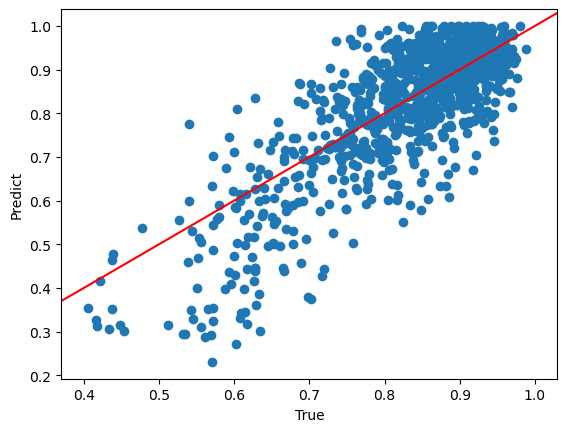

In [108]:
plt.scatter(recon_mean.cpu(), response)
plt.axline((0.4, 0.4), (1,1), c='r')
plt.xlabel('True')
plt.ylabel('Predict')

(array([  9.,  19.,  19.,  24.,  42.,  50., 113., 180., 283., 285.]),
 array([0.2304    , 0.30735999, 0.38431999, 0.46127999, 0.53824002,
        0.61519998, 0.69216001, 0.76911998, 0.84608001, 0.92303997,
        1.        ]),
 <BarContainer object of 10 artists>)

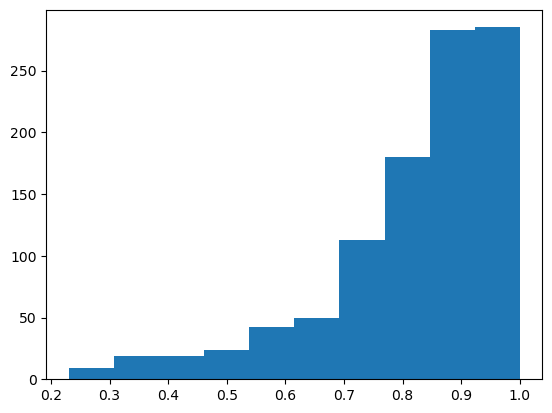

In [109]:
plt.hist(response)